# Exchange Coupling

## Objective

In this new notebook I will analyze the data from PIMC simulations with the objective of computing the exchange function. The first cells will contain the same information as in PIMC Vectorized code, as the same constants and voltages must be defined. 
later, we will define the methods 
   - ParityOfCrossings
   - NumberOfCrossings
that will count the parity and number of crossings of each path. Finally , we plot NumberOfCrossings vs Path action, where expect to obtain a random linear deviation. The expected slope should be proportional to the exchange coupling

### Set-Up Notebook

In [1]:
%matplotlib notebook
import numpy as np
from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.stats import linregress
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LinearRegression

# RC - params . Better plots
def SetPlotParams():
    '''
     Inputs:
     Return:
    '''
    plt.rcParams.update({'font.size': 25})
    plt.rc("text", usetex = True)
    plt.rc("font", family = "serif")
    plt.rcParams['figure.subplot.hspace'] = 0.3
    plt.rcParams['figure.subplot.wspace'] = 0.1
    plt.rcParams['lines.linewidth'] = 3
    plt.rcParams['axes.formatter.limits'] = -3 , 3
    plt.rc('xtick.major', pad = 1)
    plt.rc('ytick.major', pad = 1)
    plt.rcParams['axes.labelpad'] = 15
    plt.rcParams['axes.formatter.use_mathtext'] = False
    plt.rcParams['figure.autolayout'] = True
    # plt.rcParams['figure.figsize'] =  8.3, 6.8
    plt.rcParams['figure.figsize'] =  6.8, 8.3
# %%
SetPlotParams()


### List of Constants

In [2]:
## List of Constants



"""Parameters, units: ueV, nm, ns"""
print('Setting initial constants')
#N = 80 #time_steps and number of tried changes during one sweep.
num_path = 1000 #number of sweeps
print('num_paths = ', num_path)

#beta = 0.1 # imaginary total time? (/hbar?)
tau = 5*10 ** (-6) #ns
print('tau = ', tau, '(ns)')



interaction = 1 # Turn on/off electron-electron interaction (1 or 0)
h= np.array([1,.7,.08])
print('Displacement vector (h) =', h , 'nm')

eec = 1.23*10**5
print('Electron-electron coupling constant (eec) =', eec, 'ueV')
me = 5.686 * 10 **(-6) # ueV ns^2/nm^2 - electron mass
print('me = ', repr(np.round(me,9)), 'ueV*ns^2/nm^2' )
mass = 1 # Effective mass on/off

if mass == 1:
        meff= 0.2 * me #effective electron mass in Silicon
        ml = 0.98 * me #effective mass in longitudinal k-direction
        mt = 0.19 * me #effective mass in transverse k-direction
        mx = mt #effective mass in x-direction
        my = mt #effective mass in y-direction
        mz = ml #effective mass in z-direction
        m = np.array([mx,my,mz])
        print('Effective mass vector (m) = ', m,'*me' )
else:
        print('No Mass')

pot_step = 3 * 10**6 #ueV - Si/SiO2 interfac
print('Step voltage(pot_step) = ', pot_step,' $ueV$' )
        
        
# %%

hbar = 0.6582 # ueV * ns
a = 0.543 #nm - lattice constant in silicon

w = 4000/hbar
q = 10**6 # ueV
lamda = 0.5 * hbar**2 / me
r_0 = np.sqrt(hbar / (me*w))

E_z = 2 * 10**3 #ueV/nm - Electric field in z direction

# %%
Kb = 86.173324#mueV K−1
# a=10
slope = E_z
V = pot_step
x_0 = 1.5*r_0

# V_field = V_hrl

print('Lattice constant (a)=', a, 'nm')
print('Temperature -', hbar/(Kb*2000*tau), 'K')
# print('Temperature -', hbar/(6000*tau), 'K')
# HRL_Potential = 'old_UNSW4_1st withBG TEST ephiQWM UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
HRL_Potential = 'UNSW4_1st withBG TEST ephiQWM for VX1_1V UNSW4_1st structure 2nm 800x800 - 10-4-12-4.npz'
print('Setting HRL potential VX1 =1V' )
print('----------------------------- \n' )

Setting initial constants
num_paths =  1000
tau =  4.9999999999999996e-06 (ns)
Displacement vector (h) = [1.   0.7  0.08] nm
Electron-electron coupling constant (eec) = 123000.0 ueV
me =  5.686e-06 ueV*ns^2/nm^2
Effective mass vector (m) =  [1.08034e-06 1.08034e-06 5.57228e-06] *me
Step voltage(pot_step) =  3000000  $ueV$
Lattice constant (a)= 0.543 nm
Temperature - 0.7638094591778775 K
Setting HRL potential VX1 =1V
----------------------------- 



In [3]:


'''Define grid and HRL potential'''
xs = np.load(HRL_Potential)['xs']
ys = np.load(HRL_Potential)['ys']
zs = np.load(HRL_Potential)['zs']
ephi = 10**6 * np.load(HRL_Potential)['ephi']

interpolate = rgi(points = (xs,ys,zs), values = ephi, bounds_error = False, method = 'linear') #options 'linear' , 'nearest'

def ee(path1,path2):
    return(eec/dist(path1,path2))

def dist(path1,path2):
    minus = path1-path2
    return np.sqrt(minus[0,:]**2 + minus[1,:]**2 + minus[2,:]**2)

def V_hrl(path):
    return interpolate(path.T) + V_step(path[2,:])

V_field = V_hrl
print('HRL')

V_field = V_hrl
interaction = 1

def KineticEnergy(MassVec,path):
    '''Computes kinetic energy of path of an electron path
       inputs: MassVec(3*1-array)
               path(3*N-array)
       return: Energy vector(N-array)
    '''
    Rpath = np.roll(path,-1,(1))
    return (.5/(4*tau**2))*np.matmul(np.transpose(MassVec),(Rpath-path)**2)


def V_step(z_path):
    zero_arr = np.zeros((3,len(z_path)))
    zero_arr[2,:] = z_path
    return(V / (np.exp(-a*z_path) + 1) + interpolate(zero_arr.T))


def find_action(path1,path2):
    '''Computes the action given two electron paths
       inputs: Path1 , Path2: 3*N-arrays
       outputs: Action(real)
    '''
    V_interaction = interaction * np.sum(ee(path1,path2))
    
    s1 = tau*KineticEnergy(m,path1)
    s2 = tau*KineticEnergy(m,path2)
    
    s1 = np.sum(s1) + tau * np.sum(V_field(path1))# + V_interaction
    s2 = np.sum(s2) + tau * np.sum(V_field(path2))# + V_interaction
    
    s = s1 + s2 + 2 * np.log(2 * np.pi * tau / meff) + tau * V_interaction
    return s

def findPathsAction(Paths1,Paths2):
    S = []
    for NP in range(len(Paths1[:,0,0])):
        s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
        S.append(s)
    return np.array(S)
    


HRL


In [16]:
#%cd ..
# %cd VX_1V/


In [55]:
Labels = np.loadtxt('Labels.dat', dtype = str , delimiter = ' ' )

p1 = []
p2 = []
S_mean = []
S_std = []
Perm = []

for i in range(len(Labels[:,0])):
    Path = np.load('cross'+ Labels[i,0]+'/run'+ Labels[i,1] +'/path.npz')
    p1.append(Path['p1'])
    p2.append(Path['p2'])
    S_arr = np.array(Path['S_arr'])
    S_mean.append(np.mean(S_arr[-10:])) 
    S_std.append(np.std(S_arr[-10:]))
    Perm.append(Path['Perm'])

p1 = np.array(p1)
p2 = np.array(p2)
S_mean = np.array(S_mean)
S_std = np.array(S_std)
Perm = np.array(Perm)

np.savez('Paths' , p1=p1 , p2=p2 , S_mean=S_mean, S_std=S_std , Perm=Perm )


FileNotFoundError: [Errno 2] No such file or directory: 'cross00/run1/path.npz'

<IPython.core.display.Javascript object>


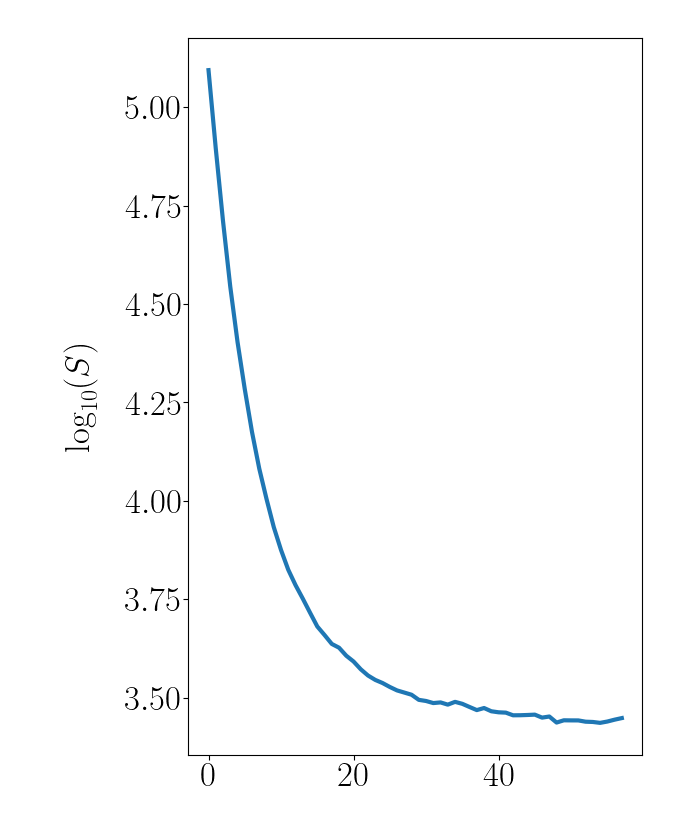

Text(0, 0.5, '$\\log_{10}(S)$')

In [12]:
n = 2

Path = np.load('cross'+ Labels[n,0]+'/run'+ Labels[n,1] +'/path.npz')
S_arr = np.array(Path['S_arr'])

fig, ax = plt.subplots(1,1)
ax.plot(range(len(S_arr)),np.log10(S_arr))
#Axis Labels
ax.set_ylabel('$\log_{10}(S)$')
#ax.set_xlabel('Iterations ($\\times'+ repr(NumMeasures) +'$)')





In [6]:
Labels = np.loadtxt('Labels.dat', dtype = str , delimiter = ' ' )
Paths = np.load('Paths.npz')
P1 = Paths['p1']
P2 = Paths['p2']
PP = Paths['Perm']
SS = Paths['S_mean']
S_STD = Paths['S_std']

print(np.shape(P1))
print(np.shape(P2))
print(np.shape(SS))

print(SS)
print(S_STD)

(35, 3, 2000)
(35, 3, 2000)
(35,)
[2843.48806052 2757.82060769 2764.92461594 2583.25364407 2764.26682784
 2870.72686991 2764.75287704 2824.18726996 2863.350837   2783.304623
 2890.30576749 2828.55776469 2814.3930732  2910.4356652  2899.0483754
 2880.48469264 2908.93590899 2866.42457272 2932.91665986 2991.16418955
 3005.72284344 2993.79306554 2857.44140513 2912.84289252 2908.28048938
 2981.73624865 2948.48473315 2822.76514659 3032.7734976  2966.69347129
 2788.93402731 2957.16963187 2848.59761285 3033.7152366  3037.90345324]
[40.10022279 29.48290627 22.31436905 33.73072989 51.33669914 30.24545867
 44.58422672 42.9036708  56.48982427 40.53353101 48.89263142 37.73684046
 20.92109319 25.53552219 20.59076418 55.06441642 34.83603876 38.7923442
 24.23671785 31.76703675 23.68514353 38.10922063 30.51987799 45.60662155
 38.09099125 22.06575644 35.35682871 22.71100303 31.37029087 34.65532029
 33.44149122 30.41825618 42.44681328 51.57268455 45.46718618]


<IPython.core.display.Javascript object>


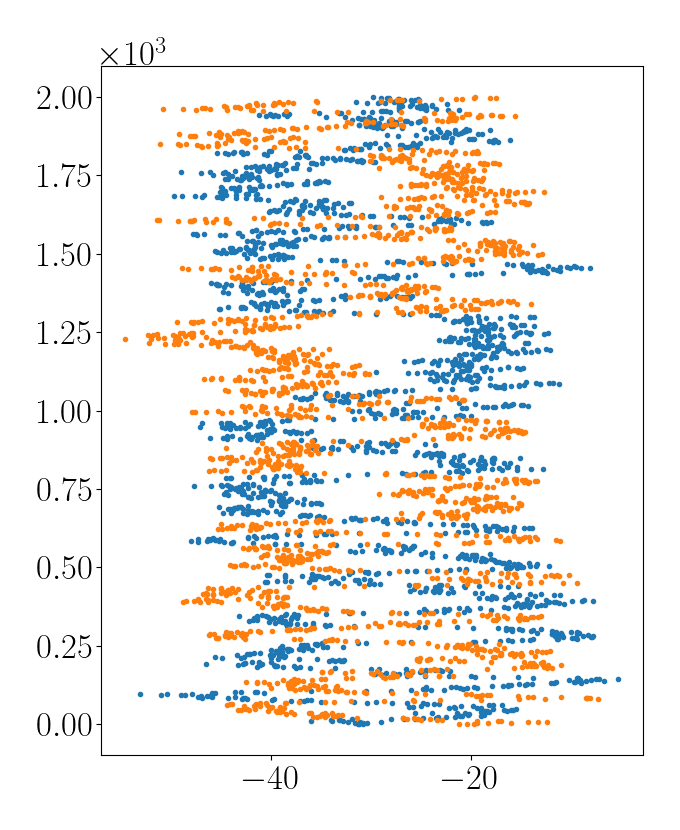

23


In [59]:

fig, ax = plt.subplots(1,1) 
# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
# # for NP in range(len(P1[:,0,0])):
NP = 23
print(NP)
ax.plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '.')
ax.plot(P2[NP,0,:], range(len(P1[NP,0,:])),'.')

In [29]:
# counts = np.linspace(0,58,59)
# counts = np.repeat(counts, 5)
# Parity = 1-(counts%2)*2
# len(counts)
# # counts = counts.reshape(-1,1)
# # Parity = 1-(counts%2)*2
# len(counts[Parity == 1])
# SS = findPathsAction(PP1,PP2)
# len(SS[Parity == -1])

In [60]:
# np.shape(counts)
# # np.shape(SS)
# Labels = Labels[:-5,:]
# SS = SS[:-5]

<IPython.core.display.Javascript object>


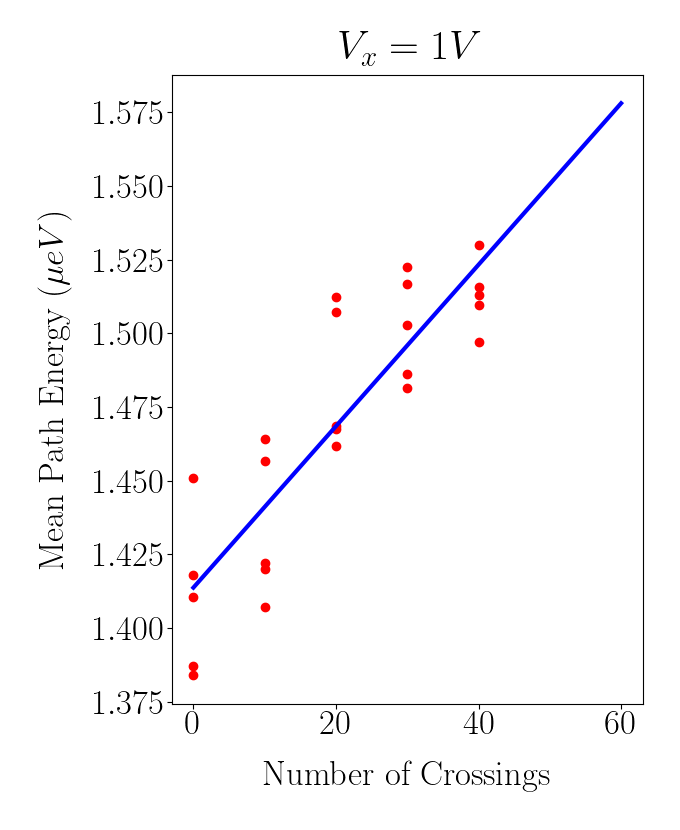

25 25
0.0027388943711611664 0.00031989925210386345 1.3131211928297956e-08
Vx=0: 2.7388943711611664 +/- 0.31989925210386344 neV = 4.161188652630153 +/- 0.4860213492918011 MHz


In [61]:
counts = Labels[:,0].astype(int)
fig, ax = plt.subplots(1,1) 
ax.plot(counts, SS/2000 , 'ro')
# counts = counts.reshape(-1,1)
regression_model = LinearRegression()
print(len(counts), len(SS/2000))

# # Model initialization
slope, intercept, r_value, p_value, std_err = stats.linregress(counts,SS/2000)



X = np.linspace(0,50,50)
ax.plot(X, intercept + X*slope, 'b-' )
ax.set_title('$V_x = 1V$')
ax.set_xlabel('Number of Crossings')
ax.set_ylabel('Mean Path Energy $(\\mu eV)$')
print(slope, std_err , p_value)
print('Vx=0:',(slope)*1000 , '+/-', std_err*1000 , 'neV =',  (slope)/hbar*10**3,'+/-', std_err/hbar*10**3 , 'MHz')

Vx=0: 2.0417019260473666 +/- 0.34150475344585085 neV = 3.1019476238945107 +/- 0.5188464804707549 MHz


<IPython.core.display.Javascript object>


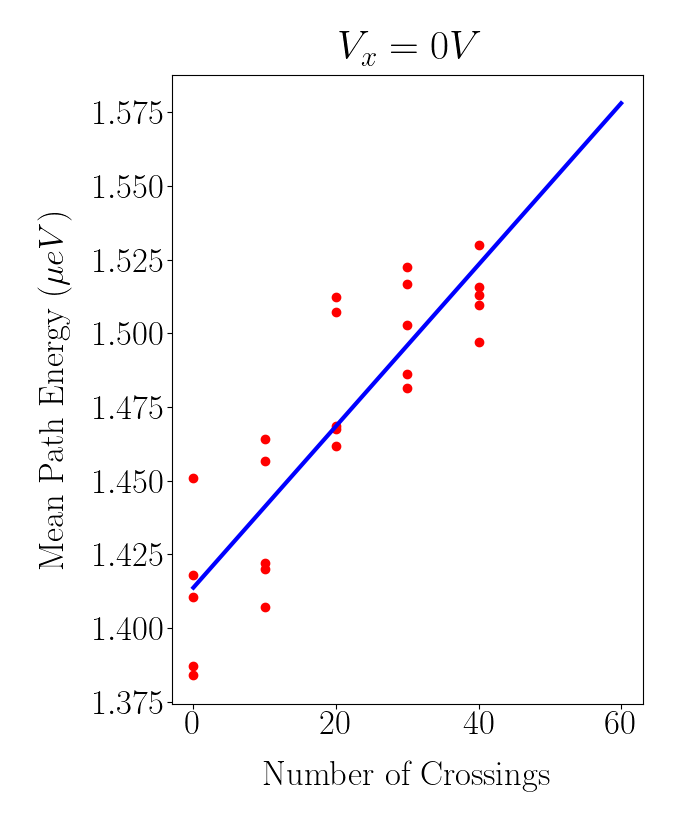

25 25
0.0027388943711611664 0.00031989925210386345 1.3131211928297956e-08
Vx=0: 2.7388943711611664 +/- 0.31989925210386344 neV = 4.161188652630153 +/- 0.4860213492918011 MHz


In [62]:
counts = Labels[:,0].astype(int)
fig, ax = plt.subplots(1,1) 
ax.plot(counts, SS/2000 , 'ro')
# counts = counts.reshape(-1,1)
regression_model = LinearRegression()
print(len(counts), len(SS/2000))

# # Model initialization
slope, intercept, r_value, p_value, std_err = stats.linregress(counts,SS/2000)



X = np.linspace(0,60,60)
ax.plot(X, intercept + X*slope, 'b-' )
ax.set_title('$V_x = 0V$')
ax.set_xlabel('Number of Crossings')
ax.set_ylabel('Mean Path Energy $(\\mu eV)$')
print(slope, std_err , p_value)
print('Vx=0:',(slope)*1000 , '+/-', std_err*1000 , 'neV =',  (slope)/hbar*10**3,'+/-', std_err/hbar*10**3 , 'MHz')

In [ ]:
# vec = np.linspace(0,4,5)
# np.roll(vec, -1)

In [ ]:


# PP1 = np.load('Paths/HundredPaths1.npy')
# PP2 = np.load('Paths/HundredPaths2.npy')
# SS = findPathsAction(PP1,PP2)

# P1 = np.load('Paths/150Paths1.npy')
# P2 = np.load('Paths/150Paths2.npy')
# Permutations  = np.load('Paths/150Permutations.npy' )
# S_mean = np.load('Paths/150S_mean.npy')
# S_std = np.load('Paths/150S_std.npy')


P1 = np.load('Paths/101VPaths1.npy')
P2 = np.load('Paths/101VPaths2.npy')
Permutations  = np.load('Paths/101VPermutations.npy' )
S_mean = np.load('Paths/101VS_mean.npy')
S_std = np.load('Paths/101VS_std.npy')


# rows = 2
# cols = 2
# fig, axarr = plt.subplots(rows,cols)
# for i in range(rows):
#     for j in range(cols):
#         NP = np.random.randint(len(P1[:,0,0]))
#         axarr[i,j].plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
#         axarr[i,j].plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')


fig, ax = plt.subplots(1,1) 
# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
# # for NP in range(len(P1[:,0,0])):
NP = 4
print(NP)
ax.plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '.')
ax.plot(P2[NP,0,:], range(len(P1[NP,0,:])),'.')


np.shape(P1)

In [ ]:
Psym1 = np.load('VX_1V/60Paths1.npy')

Psym2 = np.load('VX_1V/60Paths2.npy')

# PermSym  = np.load('VX_1V/60Perms.npy' )
S_meanSym = np.load('VX_1V/60S_mean.npy')
S_stdSym = np.load('VX_1V/60S_std.npy')
np.mean(S_meanSym)


fig, ax = plt.subplots(1,1) 
# for NP in np.random.randint(len(P1[:,0,0]),size = 1 ): 
# # for NP in range(len(P1[:,0,0])):
NP = 12
print(NP)
ax.plot(Psym1[NP,0,:], range(len(P1[NP,0,:])) , 'b.')
ax.plot(Psym2[NP,0,:], range(len(P1[NP,0,:])),'r.')


PP1  = Psym1
PP2  = Psym2
SS  = S_meanSym



In [ ]:
# Psym1 = np.load('Paths/10CroPaths1.npy')
# Psym2 = np.load('Paths/10CroPaths2.npy')

# PermSym  = np.load('Paths/10CroPermutations.npy' )
# S_meanSym = np.load('Paths/10CroS_mean.npy')
# S_stdSym = np.load('Paths/10CroS_std.npy')


# Psym1 = np.load('Paths/10Paths1.npy')
# Psym2 = np.load('Paths/10Paths2.npy')

# PermSym  = np.load('Paths/10Permutations.npy' )
# S_meanSym = np.load('Paths/10S_mean.npy')
# S_stdSym = np.load('Paths/10S_std.npy')


# # rows = 2
# cols = 2
# fig, axarr = plt.subplots(rows,cols)
# for i in range(rows):
#     for j in range(cols):
#         NP = np.random.randint(len(P1[:,0,0]))
#         axarr[i,j].plot(P1[NP,0,:], range(len(P1[NP,0,:])) , '-')
#         axarr[i,j].plot(P2[NP,0,:], range(len(P1[NP,0,:])),':')





In [ ]:
PP1  = np.concatenate((P1, Psym1), axis = 0)
PP2  =np.concatenate((P2, Psym2), axis = 0)
SS  = np.concatenate((S_mean, S_meanSym), axis = 0)
PermP = np.concatenate((Permutations, PermSym), axis = 0)
np.shape(Psym1)
np.shape(PP1)

# np.save('Paths/101VPaths1', PP1 )
# np.save('Paths/101VPaths2', PP2 )
# np.save('Paths/101VPermutations', PermP )
# np.save('Paths/101VS_mean', SS )


In [ ]:
np.shape( np.shape(np.concatenate((P1, Psym1), axis = 0)))

In [ ]:
S_std

In [ ]:
def ParityOfCrossings(Paths1,Paths2):
    '''
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return:Parity of crossings for each pair of paths

    '''
    return -(2*(NumberOfCrossings(Paths1,Paths2)%2)-1) 


def NumberOfCrossings(Paths1,Paths2):
    ''' Returns 
     Inputs: Paths1,Paths2: two collections of paths for the first and secont particles
     Return: Number of crossings for each pair of paths

    ''' 
    Sq = np.sign(Paths1[:,0,:]-Paths2[:,0,:])
    BitFunc = np.absolute(Sq[:,1:]-Sq[:,:-1])/2
    return np.sum(BitFunc, axis=1)
    

In [ ]:
counts = np.linspace(0,58,59)
counts = np.repeat(counts, 5)
Parity = 1-(counts%2)*2
len(counts)
# counts = counts.reshape(-1,1)
# Parity = 1-(counts%2)*2
len(counts[Parity == 1])
SS = findPathsAction(PP1,PP2)
len(SS[Parity == -1])

In [ ]:
# Slices = np.linspace(0,60,11)
# # Slices = np.repeat(Slices, 5)
# SS = SS[np.isin(counts,Slices)]
# counts = counts[np.isin(counts,Slices)]


## Linear Regression

We sample our montecarlo results on the mean path energy vs the number of crossings in the paths. The results can be related to a linear model where the slope represents the exchange coupling between dots. 

In [ ]:


# Parity = ParityOfCrossings(PP1,PP2)
# Parity = 1-(counts%2)*2
fig, ax = plt.subplots(1,1) 
# SS = findPathsAction(PP1,PP2)
# Even = Parity[Parity == 1]
# Odd = Parity[Parity == -1]
# S_even = S_mean[Parity == 1]
# S_odd = S_mean[Parity == -1]

# crossings = NumberOfCrossings(PP1,PP2)

# ax.scatter(crossings[Parity == 1], S_mean[Parity == 1] , 'r')
# ax.scatter(crossings[Parity == -1], S_mean[Parity == -1] , 'b')

# x = np.linspace(0,20,61)
# [len(crossings[Parity == 1]) ,len(S_mean[Parity == 1] )]
# S_mean[Parity == 1]

ax.plot(counts, SS/6000 , 'ro')


# ax.plot(counts[Parity == -1], SS[Parity == -1]/6000 , 'yo')
# ax.plot(counts[Parity == 1], SS[Parity == 1]/6000 , 'ro')


# ax.plot(crossings[:-10], SS[:-10] , 'ro')
# ax.plot(crossings[-10:-5], SS[-10:-5] , 'bo')
# ax.plot(crossings[-5:], SS[-5:] , 'go')
# print(np.mean(S_even) , np.mean(S_odd) )


# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
crossings = crossings.reshape(-1,1)

regression_model = LinearRegression()
# # Fit the data(train the model)
# reg  = regression_model.fit(counts, SS/6000)
print(len(counts), len(SS/6000))

# # Model initialization
slope, intercept, r_value, p_value, std_err = stats.linregress(counts,SS/6000)
# crossings

reg.intercept_

X = np.linspace(0,60,60)
ax.plot(X, reg.intercept_ + X*reg.coef_ , 'b-' )
ax.set_title('$V_x = 1V$')
ax.set_xlabel('Number of Crossings')
ax.set_ylabel('Mean Path Energy $(\\mu eV)$')


In [ ]:

# sd_intercept = see * sqrt(1./len(x) + mx*mx/sx2)
std_slope = std_err/np.std(counts)

# # y_predicted = regression_model.predict(x)

print('slope, intercept, r_value, p_value, std_err')
print(slope*1000, intercept*1000, r_value, p_value, std_err*1000 , 'nev')
print('slope = ',slope*1000,'+/-', std_slope*1000 , 'neV')
print('Error in slope' , 100*sd_slope/slope,'%')


In [ ]:
print('Vx=0:',(1.05935468/6000)*1000 , 'neV =',  ((1.05935468/6000))/hbar*10**3, 'MHz')
print('Vx=1:',(0.00092438*1000) , 'neV = ',  ((0.00092438))/hbar*10**3, 'MHz')


x = counts
sx2 = ((x-np.mean(x))**2).sum()
# sd_intercept = see * sqrt(1./len(x) + mx*mx/sx2)
sd_slope = std_err/np.sqrt(sx2)

# # y_predicted = regression_model.predict(x)
ax.set_title('$V_x = 1V$')
ax.set_xlabel('Number of Crossings')
ax.set_ylabel('Mean Path Energy $(\\mu eV)$')
print('slope, intercept, r_value, p_value, std_err')
print(slope*1000, intercept*1000, r_value, p_value, std_err*1000 , 'nev')
print('slope = ',slope*1000,'+-', sd_slope*1000 , 'neV')
print('Error in slope' , 100*sd_slope/slope,'%')



In [ ]:
print('Error',100*(1.0169596437937476-0.9243800000000001)/0.9243800000000001 ,'%')

In [ ]:
NumberOfCrossings(PP1,PP2)
ParityOfCrossings(PP1,PP2)
findPathsAction(PP1,PP2)
print('Action: Mean , STD  (Distribution is not taken into account yet)')
print(np.mean(findPathsAction(P1,P2)),' , ',np.std(findPathsAction(P1,P2)))
print('Number of Crossings: Mean , STD')
print(np.mean(NumberOfCrossings(P1,P2)),' , ',np.std(NumberOfCrossings(P1,P2)))
print('Count of Odd Crossings')
print(sum(ParityOfCrossings(P1,P2)==-1))
print('Count of Even Crossings')
print(sum(ParityOfCrossings(P1,P2)==1))

In [ ]:
ParityOfCrossings(P1,P2)==-1
oddargs = np.argwhere(ParityOfCrossings(P1,P2)==-1)
P1_odd = P1[oddargs[:,0],:,:]
P2_odd = P2[oddargs[:,0],:,:]

In [ ]:

DeltaS = np.sum(findPathsAction(P1_odd,P2_odd))-np.sum(findPathsAction(P1,P2))
J = -DeltaS
DeltaS/100

In [ ]:
np.sum(findPathsAction(P1_odd,P2_odd))/4049.071020506987

np.sum(findPathsAction(P1,P2))/4049.071020506987
print((1/(tau*1000))*np.log(37/(100-37)), 'THz' )

In [ ]:
13.46582018

In [ ]:
np.mean(findPathsAction(P1,P2))

In [ ]:
#findPathsAction(P1_odd,P2_odd)/hbar #- np.sum(-findPathsAction(P1,P2)/hbar)
S = []
Paths1 = P1_odd
Paths2 = P2_odd
for NP in range(len(Paths1[:,0,0])):
    s = find_action(Paths1[NP,:,:],Paths2[NP,:,:])
    S.append(s)
S

In [ ]:
np.shape(P1_odd)


In [ ]:
NP =15

fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
# A = P1[NP,0,:]-P2[NP,0,:]
ax.plot( A  , range(len(P2[NP,0,:])))
ParityOfCrossings(P1,P2)[20]

In [ ]:
fig, ax = plt.subplots(1,1)

A = np.sign(P1[NP,0,:]-P2[NP,0,:])
ax.plot( np.absolute(A[1:]-A[:-1])/2  , range(len(P2[NP,0,:])-1))



In [ ]:
sum(np.absolute(A[1:]-A[:-1])/2)

In [ ]:
%cd VX_1V/
%ls